In [1]:
import geopandas
import r5py.sampledata.helsinki
import shapely
import pandas as pd
import geopandas as gpd
import numpy as np

import os
import snman
from snman import osmnx_customized as oxc
from snman.constants import *

PERIMETER = '_accessibility_debug'

# Set these paths according to your own setup
data_directory = os.path.join('C:',os.sep,'Users','lballo','polybox','Research','SNMan','SNMan Shared','data_v2')
inputs_path = os.path.join(data_directory, 'inputs')
process_path = os.path.join(data_directory, 'process', PERIMETER)
outputs_path = os.path.join(data_directory, 'outputs', PERIMETER)

CRS_internal = 2056      # for Zurich

C:\APPS\Anaconda3\envs\ebc39a\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\lballo\AppData\Roaming\Python\Python39\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
print('Load street graph')
G = snman.io.load_street_graph(
    os.path.join(process_path, 'street_graph_edges.gpkg'),
    os.path.join(process_path, 'street_graph_nodes.gpkg'),
    crs=CRS_internal
)

snman.street_graph.organize_edge_directions(G)

Load street graph


In [3]:
print('Load statpop')
statpop = snman.io.import_geofile_to_gdf(
    os.path.join(inputs_path, 'switzerland', 'switzerland', 'statpop', 'statpop2017_zrh_north-west.gpkg')
)

Load statpop


In [4]:
nodes = oxc.graph_to_gdfs(G, edges=False)
# add an id column for r5
nodes['id'] = nodes.index

In [5]:
import geopandas as gpd

statpop = gpd.sjoin_nearest(statpop, nodes, how='left', max_distance=100, rsuffix='right', distance_col='distance')
statpop.rename(columns={'id': 'from_id'}, inplace=True)
statpop.set_index('record', inplace=True)

In [6]:
transport_network = r5py.TransportNetwork(
    os.path.join(outputs_path, 'after_oneway_links_01.pbf'),
)

In [7]:
origins = geopandas.GeoDataFrame(
    {
        "id": ["origin"],
        "geometry": [shapely.Point(2682699.0, 1250903.9)]
    },
    crs="EPSG:2056",
)

destinations = geopandas.GeoDataFrame(
    {
        "id": ["destination"],
        "geometry": [shapely.Point(2682650.6, 1250981.0)]
    },
    crs="EPSG:2056",
)

In [8]:
import datetime
import numpy as np

tt_computers = {}
tt_computers[MODE_FOOT] = r5py.TravelTimeMatrixComputer(
    transport_network,
    origins=nodes.to_crs(4326),
    destinations=nodes.to_crs(4326),
    snap_to_network=True,
    departure=datetime.datetime(2022, 2, 22, 8, 30),
    transport_modes=[
        r5py.TransportMode.WALK
    ],
    max_bicycle_traffic_stress=4
)

tt_computers[MODE_CYCLING] = r5py.TravelTimeMatrixComputer(
    transport_network,
    origins=nodes.to_crs(4326),
    destinations=nodes.to_crs(4326),
    snap_to_network=True,
    departure=datetime.datetime(2022, 2, 22, 8, 30),
    transport_modes=[
        r5py.TransportMode.BICYCLE
    ],
    max_bicycle_traffic_stress=4
)

# travel time matrix calculation: compute travel times, add a mode label
def tt_calculation(tt_computer, mode):
    tt_matrix = tt_computer.compute_travel_times()
    tt_matrix['mode'] = mode
    return tt_matrix

# calculate a travel time matrix for each mode
tt_matrices = {mode: tt_calculation(tt_computer, mode) for mode, tt_computer in tt_computers.items()}

# merge all travel time matrices into one
tt_matrix = pd.concat(tt_matrices.values())

# add base travel time to avoid 0 values
tt_matrix['travel_time'] = tt_matrix['travel_time'] + 2

C:\Users\lballo\AppData\Roaming\Python\Python39\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
C:\Users\lballo\AppData\Roaming\Python\Python39\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
C:\Users\lballo\AppData\Roaming\Python\Python39\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, con

In [9]:
import pandas as pd
import geopandas as gpd

accessibility_costs = pd.merge(statpop.reset_index(), tt_matrix, on='from_id', how='left')
accessibility_costs.sort_values(['record', 'to_id', 'mode'], inplace=True)

In [10]:
accessibility_costs.query('record==2951 and to_id==12')

,record,statyear,yearofbirth,sex,maritalstatus,residencepermit,age,residentpermit,federalbuildingid,geometry,...,x,y,street_count,layers,elevation,from_id,distance,to_id,travel_time,mode
267,2951,2017,1992,2,1,202,25,2,899849017,POINT (2682791.001 1251184.001),...,2.682751e+06,1.251226e+06,3.0,{0},454.48996,12.0,57.74214,12.0,2.0,cycling
218,2951,2017,1992,2,1,202,25,2,899849017,POINT (2682791.001 1251184.001),...,2.682751e+06,1.251226e+06,3.0,{0},454.48996,12.0,57.74214,12.0,2.0,foot


In [11]:
tt_matrix

,from_id,to_id,travel_time,mode
0,0,0,2,foot
1,0,1,19,foot
2,0,2,16,foot
3,0,3,14,foot
4,0,4,14,foot
...,...,...,...,...
2396,53,48,4,cycling
2397,53,50,7,cycling
2398,53,51,4,cycling
2399,53,52,6,cycling


In [12]:
ag = accessibility_costs.groupby(['record', 'to_id']).agg({
    'travel_time': list,
    'mode': list
})

In [13]:
ag.reset_index(inplace=True)

In [14]:
ag.head(50)

,record,to_id,travel_time,mode
0,2866,0.0,"[8.0, 18.0]","[cycling, foot]"
1,2866,1.0,"[8.0, 5.0]","[cycling, foot]"
2,2866,2.0,"[3.0, 4.0]","[cycling, foot]"
3,2866,3.0,"[6.0, 8.0]","[cycling, foot]"
4,2866,4.0,"[11.0, 14.0]","[cycling, foot]"
5,2866,5.0,"[8.0, 20.0]","[cycling, foot]"
6,2866,6.0,"[9.0, 19.0]","[cycling, foot]"
7,2866,7.0,"[6.0, 12.0]","[cycling, foot]"
8,2866,8.0,"[6.0, 12.0]","[cycling, foot]"
9,2866,9.0,"[8.0, 13.0]","[cycling, foot]"


In [15]:
ag = pd.merge(ag, nodes, left_on='to_id', right_on='id')

In [16]:
ag.head()

,record,to_id,travel_time,mode,osmid_original,traffic_signals,highway,_include_in_simplification,x,y,street_count,layers,elevation,geometry,id
0,2866,0.0,"[8.0, 18.0]","[cycling, foot]",0,0,None,1,2.682650e+06,1.250982e+06,3,{0},464.329987,POINT (2682650.197 1250981.789),0
1,2866,1.0,"[8.0, 5.0]","[cycling, foot]",1,1,"{nan, 'traffic_signals'}",1,2.681991e+06,1.251791e+06,3,{0},456.029846,POINT (2681991.029 1251791.245),1
2,2866,2.0,"[3.0, 4.0]","[cycling, foot]",2,0,None,1,2.682359e+06,1.251703e+06,3,{0},453.315460,POINT (2682359.421 1251702.734),2
3,2866,3.0,"[6.0, 8.0]","[cycling, foot]",3,0,{nan},1,2.682564e+06,1.251651e+06,3,{0},451.304047,POINT (2682563.802 1251651.317),3
4,2866,4.0,"[11.0, 14.0]","[cycling, foot]",4,0,{nan},1,2.682953e+06,1.251556e+06,4,{0},449.524719,POINT (2682953.284 1251555.696),4


In [17]:
ag['travel_options'] = ag.apply(lambda row: dict(zip(row['mode'], row['travel_time'])), axis=1)

In [18]:
def calculate_behavioral_cost(travel_options):
    values = list(travel_options.values())
    return np.mean(values)

ag['behavioral_cost'] = ag['travel_options'].apply(lambda row: calculate_behavioral_cost(row))

In [19]:
ag['accessibility_contribution'] = 1 / ag['behavioral_cost']

In [20]:
ag.head(150)

,record,to_id,travel_time,mode,osmid_original,traffic_signals,highway,_include_in_simplification,x,y,street_count,layers,elevation,geometry,id,travel_options,behavioral_cost,accessibility_contribution
0,2866,0.0,"[8.0, 18.0]","[cycling, foot]",0,0,None,1,2.682650e+06,1.250982e+06,3,{0},464.329987,POINT (2682650.197 1250981.789),0,"{'cycling': 8.0, 'foot': 18.0}",13.0,0.076923
1,2866,1.0,"[8.0, 5.0]","[cycling, foot]",1,1,"{nan, 'traffic_signals'}",1,2.681991e+06,1.251791e+06,3,{0},456.029846,POINT (2681991.029 1251791.245),1,"{'cycling': 8.0, 'foot': 5.0}",6.5,0.153846
2,2866,2.0,"[3.0, 4.0]","[cycling, foot]",2,0,None,1,2.682359e+06,1.251703e+06,3,{0},453.315460,POINT (2682359.421 1251702.734),2,"{'cycling': 3.0, 'foot': 4.0}",3.5,0.285714
3,2866,3.0,"[6.0, 8.0]","[cycling, foot]",3,0,{nan},1,2.682564e+06,1.251651e+06,3,{0},451.304047,POINT (2682563.802 1251651.317),3,"{'cycling': 6.0, 'foot': 8.0}",7.0,0.142857
4,2866,4.0,"[11.0, 14.0]","[cycling, foot]",4,0,{nan},1,2.682953e+06,1.251556e+06,4,{0},449.524719,POINT (2682953.284 1251555.696),4,"{'cycling': 11.0, 'foot': 14.0}",12.5,0.080000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2951,52.0,"[9.0, 19.0]","[cycling, foot]",53,0,None,None,2.682049e+06,1.251782e+06,2,{0},456.623169,POINT (2682048.696 1251781.828),52,"{'cycling': 9.0, 'foot': 19.0}",14.0,0.071429
146,2951,53.0,"[5.0, 13.0]","[cycling, foot]",54,0,None,None,2.682336e+06,1.251556e+06,2,{0},457.029358,POINT (2682335.607 1251555.789),53,"{'cycling': 5.0, 'foot': 13.0}",9.0,0.111111
147,3057,0.0,"[5.0, 11.0]","[cycling, foot]",0,0,None,1,2.682650e+06,1.250982e+06,3,{0},464.329987,POINT (2682650.197 1250981.789),0,"{'cycling': 5.0, 'foot': 11.0}",8.0,0.125000
148,3057,1.0,"[7.0, 10.0]","[cycling, foot]",1,1,"{nan, 'traffic_signals'}",1,2.681991e+06,1.251791e+06,3,{0},456.029846,POINT (2681991.029 1251791.245),1,"{'cycling': 7.0, 'foot': 10.0}",8.5,0.117647


In [21]:
accessibility = ag.groupby('record').agg({
    'accessibility_contribution': 'sum'
})

accessibility.rename(columns={'accessibility_contribution': 'accessibility'}, inplace=True)

accessibility = accessibility.join(statpop)
accessibility = gpd.GeoDataFrame(accessibility, crs=2056)

<Axes: >

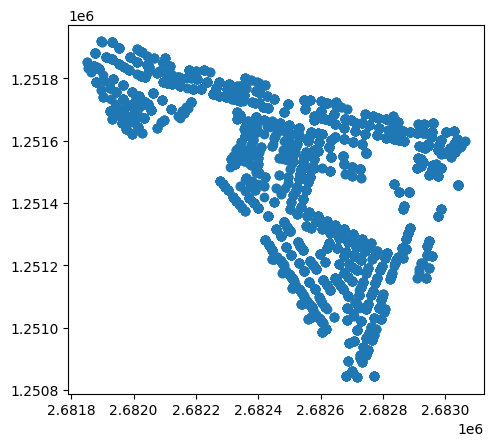

In [22]:
accessibility.plot()

In [23]:
accessibility.drop(columns=('layers'), inplace=True)

In [24]:
snman.io.export_gdf(
    accessibility,
    os.path.join(outputs_path, 'accessibility.gpkg')
)

In [25]:
if 0:
    for column in ['transport_mode', 'travel_time']:
        travel_times[column] = travel_times[column].astype(str)
    travel_times.to_file(os.path.join(outputs_path, 'routes.gpkg'))